In [1]:
import tensorflow as tf
import numpy as np
import random

#tf.compat.v1.enable_eager_execution()
# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for Python's built-in random module
random.seed(42)

from pathlib import Path
import imghdr
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

C:\Users\Sara Limeta\AppData\Local\Temp\ipykernel_25436\284860553.py:16: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


Found 985 files belonging to 3 classes.
Using 788 files for training.
Found 985 files belonging to 3 classes.
Using 197 files for validation.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


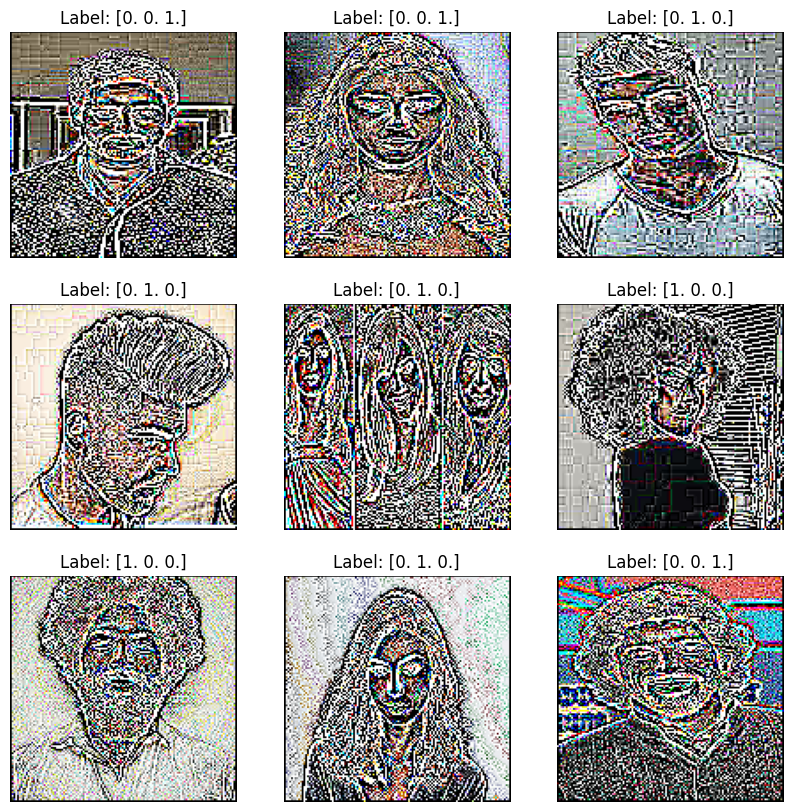

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

image_size = (128, 128)
batch_size = 32
    
def laplacian_sharpening(image):
    # Define the Laplacian kernel
    laplacian_kernel = tf.constant([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=tf.float32)
    laplacian_kernel = tf.reshape(laplacian_kernel, [3, 3, 1, 1])  # Reshape to match convolution requirements
    
    # Split the input image into individual color channels
    channels = tf.unstack(image, axis=-1)
    
    # Apply Laplacian sharpening to each color channel separately
    sharpened_channels = []
    for channel in channels:
        # Expand dimensions to match convolution requirements
        channel = tf.expand_dims(channel, axis=-1)
        
        # Apply convolution to the channel
        sharpened_channel = tf.nn.conv2d(channel, laplacian_kernel, strides=[1, 1, 1, 1], padding='SAME')
        
        # Remove the expanded dimension
        sharpened_channel = tf.squeeze(sharpened_channel, axis=-1)
        
        sharpened_channels.append(sharpened_channel)
    
    # Stack the sharpened channels along the depth dimension
    sharpened_image = tf.stack(sharpened_channels, axis=-1)
    
    # Scale the sharpened image to match the original image
    scaled_sharpened_image = sharpened_image * 25.0  # Adjust the scaling factor as needed
    
    # Add the scaled sharpened image to the original image
    enhanced_image = image + scaled_sharpened_image
    
    return enhanced_image

    
def preprocess_image(image, label):
   
    sharpened_image = laplacian_sharpening(image)
    normalized_image = sharpened_image / 255.0
    return normalized_image, label


# Load the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
).map(preprocess_image)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size, 
    labels='inferred',
    label_mode='categorical'
).map(preprocess_image)

# Display a few preprocessed images from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        #plt.imshow(images[i])  # Normalize pixel values to [0, 1]
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
plt.show()




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


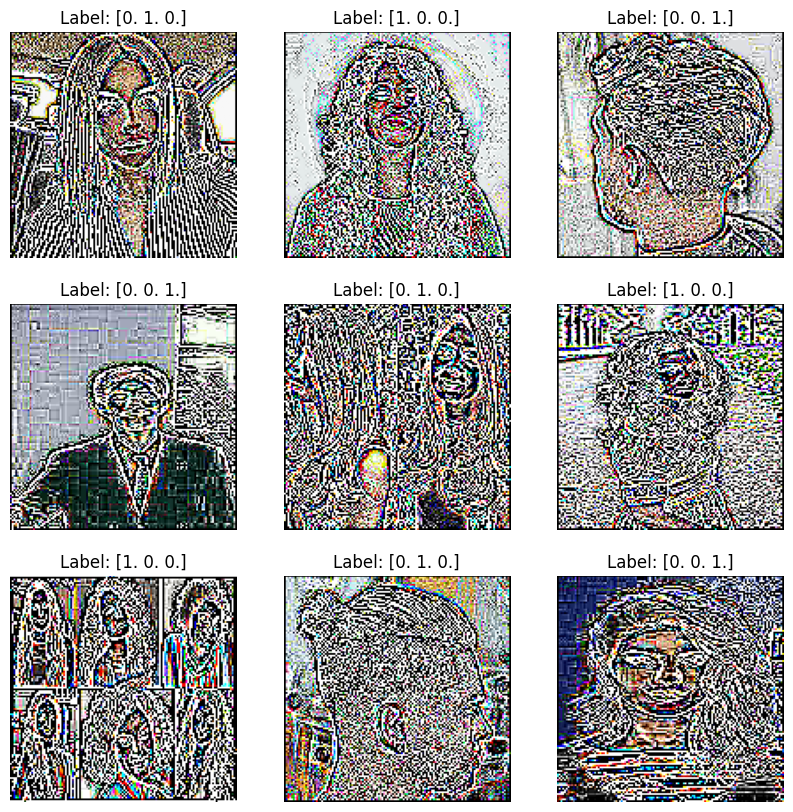

In [3]:

# Display a few preprocessed images from the training dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i], cmap='gray')
 # Normalize pixel values to [0, 1]
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
plt.show()

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
import time

#cropping_size = (52, 52)
#rotation_range = 0.6

model = Sequential()
model.add(keras.Input(shape=image_size + (3,))) # 64, 64, 3

model.add(layers.Conv2D(filters=4, kernel_size=(3,3), strides=1, padding='valid', dilation_rate=1))
#model.add(layers.BatchNormalization()) 
model.add(layers.Activation("swish"))
#model.add(layers.Dropout(0.2))  

model.add(layers.Conv2D(filters=8, kernel_size=(3,3), strides=1, padding='valid', dilation_rate=1))
#model.add(layers.BatchNormalization()) 
model.add(layers.Activation("swish"))
#model.add(layers.Dropout(0.2)) 

model.add(layers.Conv2D(filters=16, kernel_size=(3,3), strides=1, padding='valid', dilation_rate=1))
#model.add(layers.BatchNormalization()) 
model.add(layers.Activation("swish"))
#model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='valid', dilation_rate=1))
#model.add(layers.BatchNormalization()) 
model.add(layers.Activation("swish"))
#model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='valid', dilation_rate=1))
#model.add(layers.BatchNormalization()) 
model.add(layers.Activation("swish"))
#model.add(layers.Dropout(0.2))

model.add(layers.GlobalAveragePooling2D())
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='swish'))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

from tensorflow.keras.callbacks import EarlyStopping

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# Compile your model again
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

epochs = 100

start_time = time.time()
# Train your model with the EarlyStopping callback
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[callback])
#history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
end_time = time.time()

training_time = end_time - start_time
print("Training time: {:.2f} seconds".format(training_time))

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(val_ds)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy, AUC, CategoricalCrossentropy, F1Score
import tensorflow as tf
pre = Precision()
re = Recall()
cat = CategoricalAccuracy()
cc = CategoricalCrossentropy()
auc = AUC()
f1score = F1Score()

# Initialize lists to store true labels and predicted labels
true_labels_list = []
predicted_labels_list = []

for batch in val_ds.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    cat.update_state(y, yhat)
    cc.update_state(y, yhat)
    auc.update_state(y, yhat)
    f1score.update_state(y, yhat)

# Convert one-hot encoded labels to class indices
    true_labels = np.argmax(y, axis=1)
    predicted_labels = np.argmax(yhat, axis=1)
    model.add(layers.Flatten()) 
    # Append true and predicted labels to lists
    true_labels_list.extend(true_labels)
    predicted_labels_list.extend(predicted_labels)


print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Categorical Accuracy: {cat.result().numpy()}, Categorical Crossentropy: {cc.result().numpy()}, AUC: {auc.result().numpy()}, F1Score: {f1score.result().numpy()}')


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.3451 - loss: 1.0875 - val_accuracy: 0.4061 - val_loss: 1.0736
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 398ms/step - accuracy: 0.4592 - loss: 1.0572 - val_accuracy: 0.3959 - val_loss: 1.0815
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 409ms/step - accuracy: 0.4449 - loss: 1.0496 - val_accuracy: 0.3858 - val_loss: 1.0915
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 380ms/step - accuracy: 0.4510 - loss: 1.0502 - val_accuracy: 0.4365 - val_loss: 1.0282
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.4598 - loss: 1.0404 - val_accuracy: 0.4416 - val_loss: 1.0222
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 380ms/step - accuracy: 0.4785 - loss: 1.0111 - val_accuracy: 0.4315 - val_loss: 1.0135
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 374ms/step - accuracy: 0.4652 - loss: 1.0280 - val_accuracy: 0.4315 - val_loss: 1.0132
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 380ms/step - accuracy: 0.4877 - loss: 1.0205 - 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


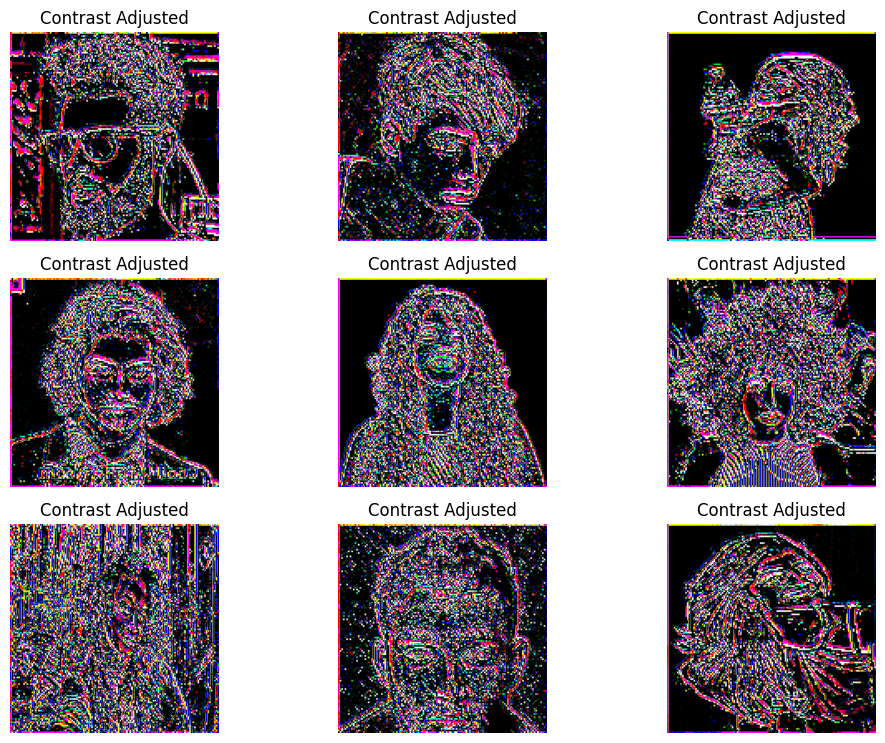

In [5]:
import matplotlib.pyplot as plt

# Function to display original and contrast-adjusted images
def display_contrast_effect(original_images, contrast_adjusted_images, num_images=9):
    num_rows = 4
    num_cols = 3
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        # Display original images
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(original_images[i].numpy().astype("uint8"))
        plt.title('Original')
        plt.axis("off")
        
        # Display contrast-adjusted images
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(contrast_adjusted_images[i].numpy().squeeze(), cmap='gray')
        plt.title('Contrast Adjusted')
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Select a batch of images from the validation dataset
sample_images, _ = next(iter(val_ds))

# Perform inference using the trained model
contrast_adjusted_images = model.layers[0](sample_images, training=True)

# Display the original and contrast-adjusted images
display_contrast_effect(sample_images, contrast_adjusted_images)


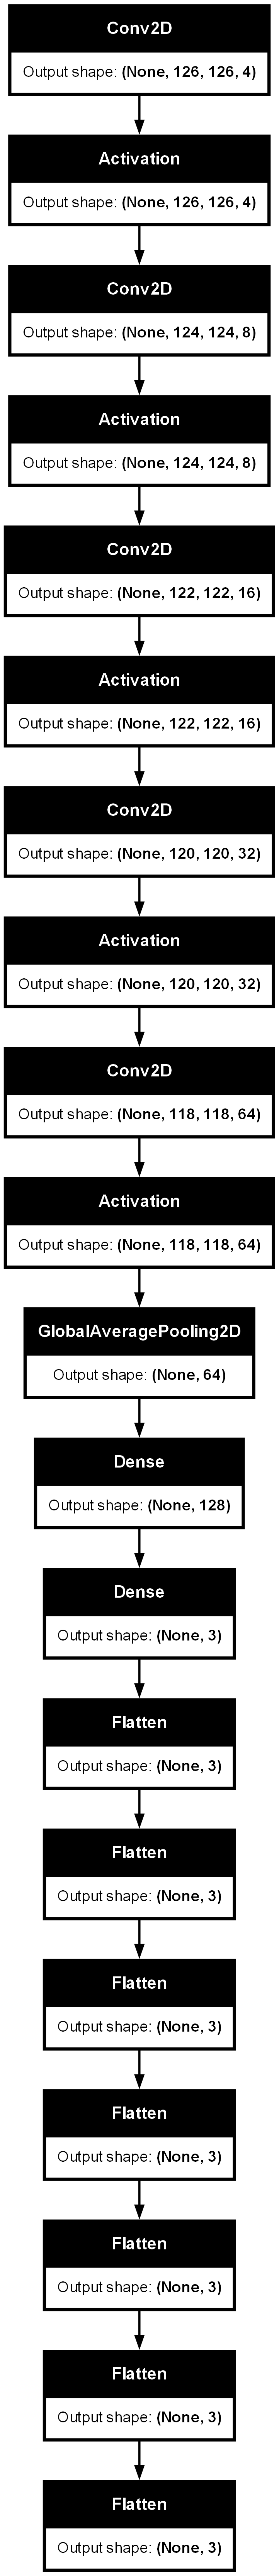

In [6]:
tf.keras.utils.plot_model(model, to_file='model_test.png', show_shapes=True)

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 4)         │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 126, 126, 4)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 124, 124, 8)         │             296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 124, 124, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 122, 122, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 122, 122, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 120, 120, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 120, 120, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 118, 118, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 118, 118, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 3)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,259 (391.64 KB)

 Trainable params: 33,419 (130.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 66,840 (261.10 KB)

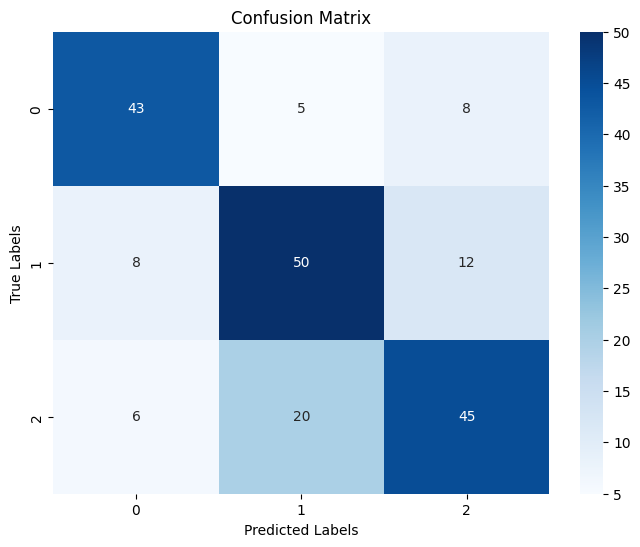

In [8]:
# Calculate confusion matrix
import seaborn as sns

conf_matrix = tf.math.confusion_matrix(labels=true_labels_list, predictions=predicted_labels_list)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

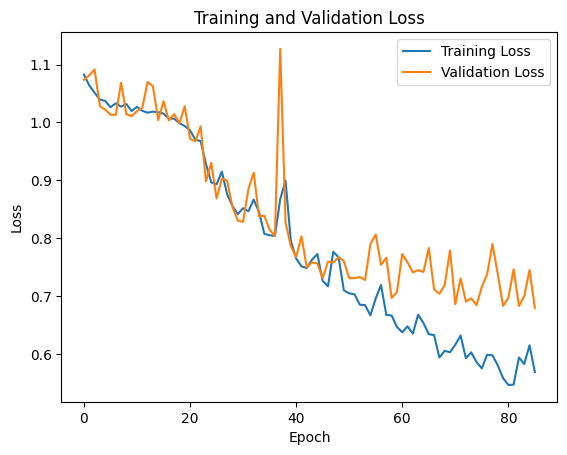

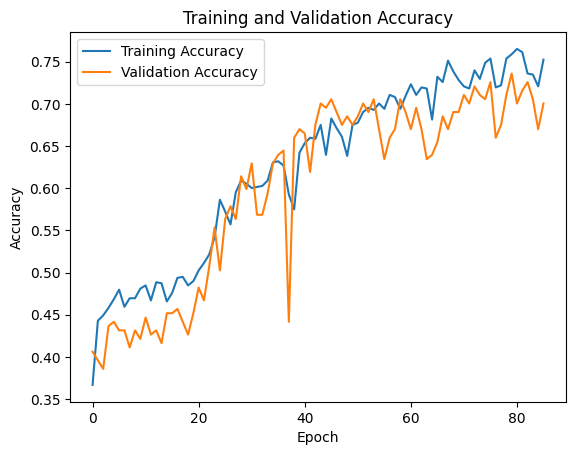

In [9]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
This image is 0.00 percent curly hair, 0.96 percent straight hair, and 0.04 percent wavy hair.


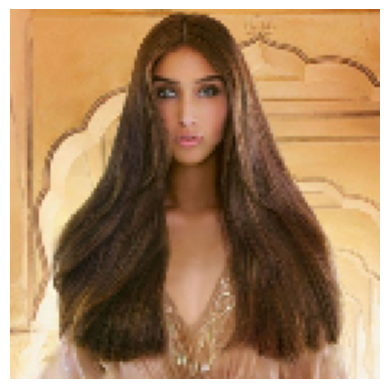

In [15]:
img = keras.preprocessing.image.load_img(
    "hair_types/Straight_Hair/8881976_f496.jpg", target_size=image_size
)

plt.axis("off")
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[0])
)
